In [16]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 0

import pandas as pd
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)
from PIL import Image

# Getting images sizes

We want to resize all images to have the same size.<br>
The chosen size is the largest height and width among all images.<br>
The left upper corner of the image is the origin.<br>

In [3]:
# read the train metadata file
metadata_path = repo_path / 'data/challange_2023/Train/extended_metadata.csv'
# read 'shape' column as tuple
metadata = pd.read_csv(metadata_path, converters={'shape': eval})
shapes = metadata['shape'].values
# get max unique x and y values
max_x = max([shape[0] for shape in shapes])
max_y = max([shape[1] for shape in shapes])
print(f'Max x: {max_x}, Max y: {max_y}')

Max x: 865, Max y: 682


From analizing the Train and Val set, it is clear that the largest height and width are (865, 682).

# Expanding images

- Let's expand all images to 865x865 pixels, ensuring a square shape.

The original dtype is uint8
Expanding y dimension


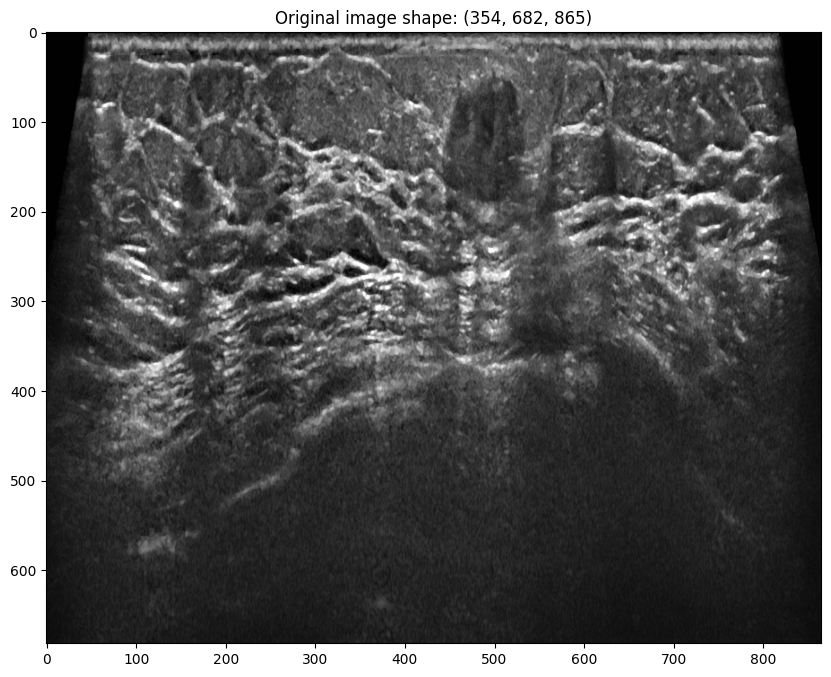

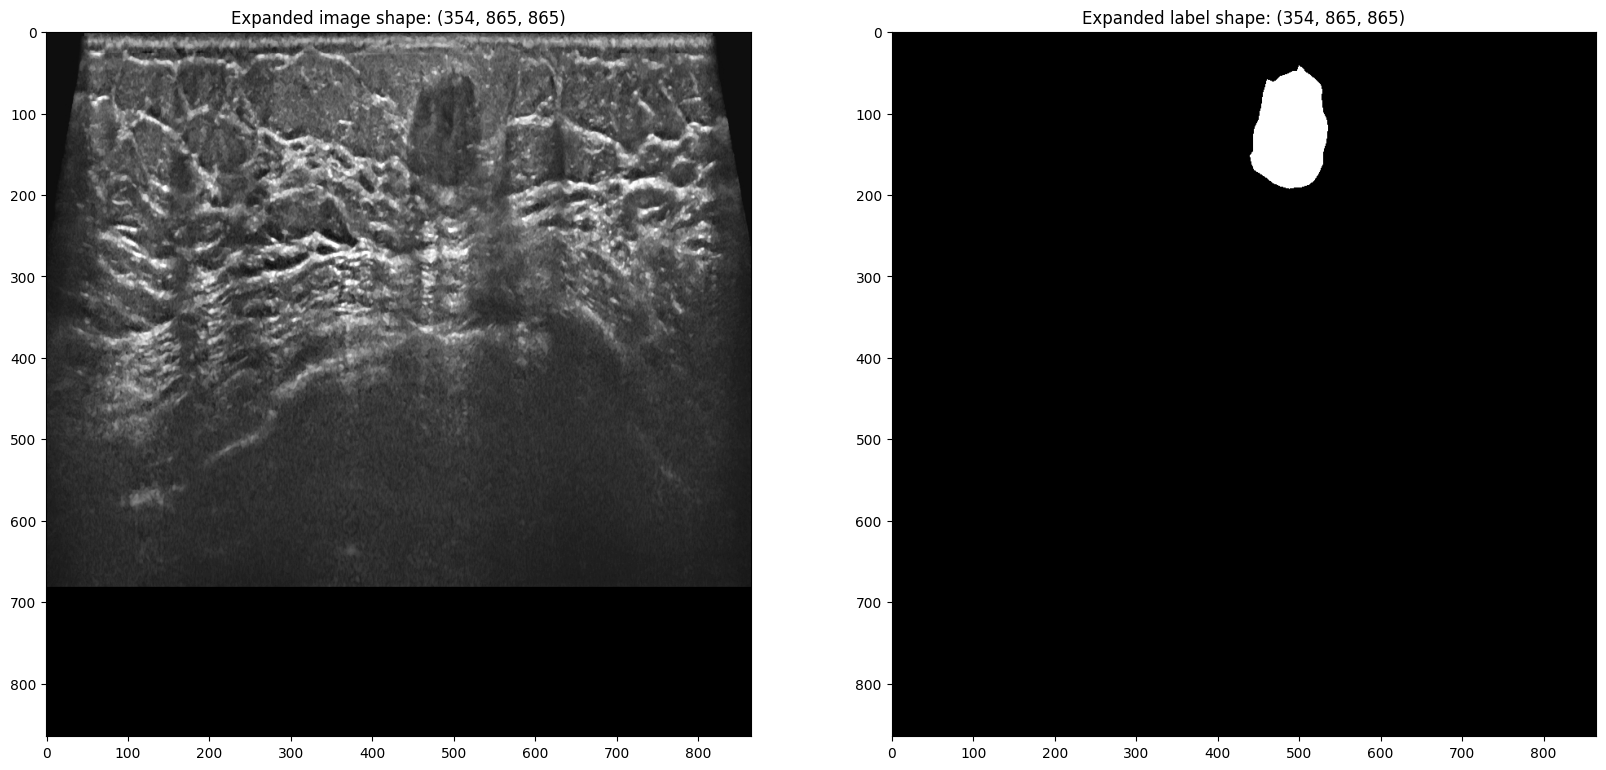

In [76]:
# Expansion HP
x_expansion = 865
y_expansion = 865

x_resizing = 512
y_resizing = 512


# transforms
preprocess_im = Compose(
        [
            Resize((x_resizing, y_resizing), interpolation= InterpolationMode.BILINEAR),
        ]
)

preprocess_label = Compose(
        [
            Resize((x_resizing, y_resizing), interpolation= InterpolationMode.NEAREST), 
        ]
)

low_res_trans = Compose(
        [ 
            Resize((x_resizing//4, y_resizing//4), interpolation= InterpolationMode.NEAREST), 
        ]
)

# read image
image_path = repo_path / 'data/challange_2023/Train/DATA/DATA_002.nrrd'
label_path = repo_path / 'data/challange_2023/Train/MASK/MASK_002.nrrd'
im = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))
print(f'The original dtype is {im.dtype}')

# plot the image
plt.figure(figsize=(10,10))
plt.imshow(im[150], cmap='gray')
plt.title(f'Original image shape: {im.shape}')

slice_num = 150
# now, we complete the x dimensions to 865
if im.shape[2]<x_expansion:
    print('Expanding x dimension')
    im = np.concatenate((im, np.zeros((im.shape[0], im.shape[1], x_expansion-im.shape[2]), dtype=np.uint8)), axis=2, dtype=np.uint8)
    label = np.concatenate((label, np.zeros((label.shape[0], label.shape[1], x_expansion-label.shape[2]), dtype=np.uint8)), axis=2, dtype=np.uint8)
    # plot
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ax[0].imshow(im[slice_num], cmap='gray')
    ax[0].set_title(f'Expanded image shape: {im.shape}')
    ax[1].imshow(label[slice_num], cmap='gray')
    ax[1].title(f'Expanded label shape: {label.shape}')
if im.shape[1]<y_expansion:
    print('Expanding y dimension')
    im = np.concatenate((im, np.zeros((im.shape[0], y_expansion-im.shape[1], im.shape[2]), dtype=np.uint8)), axis=1, dtype=np.uint8)
    label = np.concatenate((label, np.zeros((label.shape[0], y_expansion-label.shape[1], label.shape[2]), dtype=np.uint8)), axis=1, dtype=np.uint8)
    # plot
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ax[0].imshow(im[slice_num], cmap='gray')
    ax[0].set_title(f'Expanded image shape: {im.shape}')
    ax[1].imshow(label[slice_num], cmap='gray')
    ax[1].set_title(f'Expanded label shape: {label.shape}')

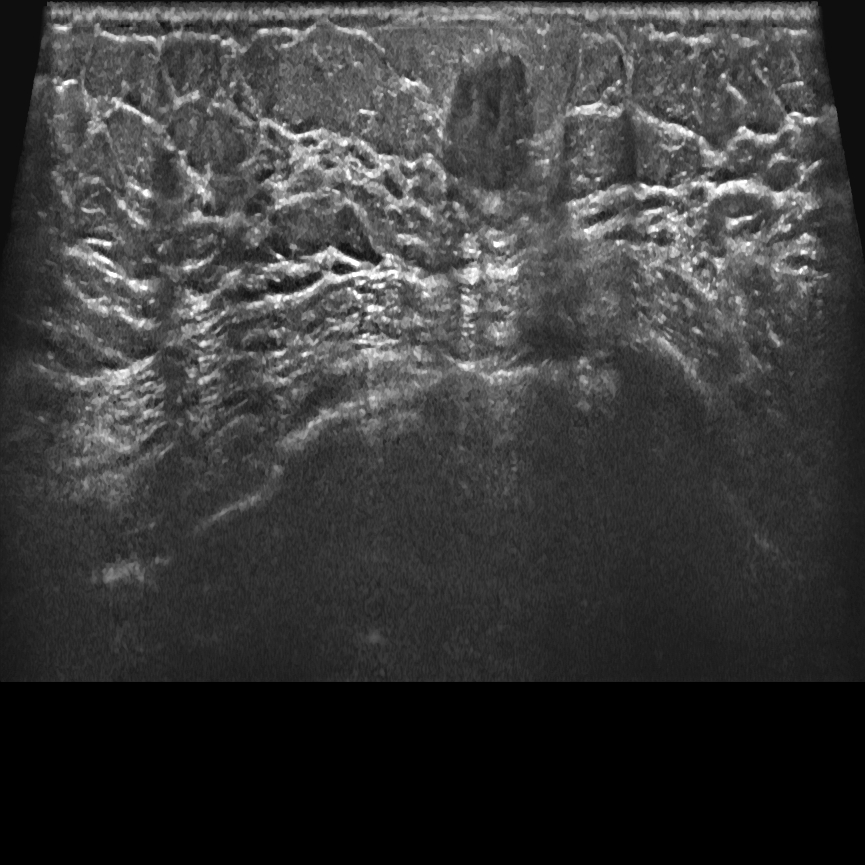

In [83]:
# preprocess image
im_slice = Image.fromarray(im[slice_num])
im_slice

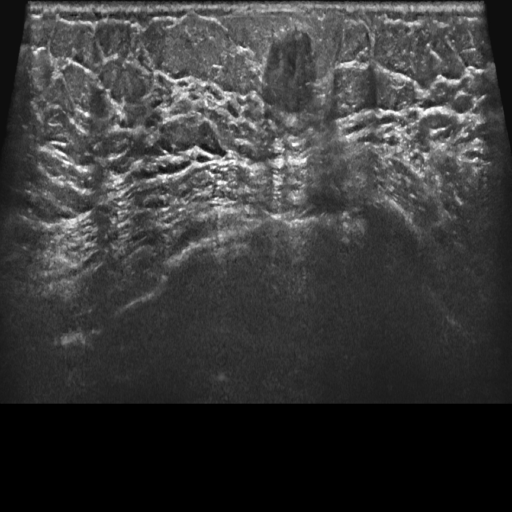

In [84]:
im_slice = preprocess_im(im_slice)
im_slice